<a href="https://colab.research.google.com/github/capitaineoblivious/operations_research/blob/master/production_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -q pyomo
!apt-get install -y -q coinor-cbc

Reading package lists...
Building dependency tree...
Reading state information...
coinor-cbc is already the newest version (2.9.9+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

## A Production planning

A firm is planning the production of 3 products A1, A2, A3. We will here try to find the best production planning for the firm in an iterative manner, increasing the level of details at each step.

### Introduction

In a month production can be active for 22 days. In the following table are given: maximum demand in a month (units=100kg), selling price of a unit (\\$/100Kg), production costs per unit (per 100Kg of product), and production quotas (maximum amount of 100kg units of product that would be produced in a day if all production lines were dedicated to the product).

We also provide activation costs ( $) which are the cost incurred when we decide to activate a production line during the month, and a minimum production batch (units/day), which is the maximum quantity that can be produced per day if we decide to activate a production line.


| Product          | $A_1 $  | $A_2 $  |  $A_3  $ |
|------------------|-------|-------|-------|
| Maximum demand   | 5300  | 4500  | 5400  |
| Selling price    | 124   | 109   | 115   |
| Production cost  | 73.3  | 52.9  | 65.4  |
| Production quota | 500   | 450   | 550   |
| Activation cost | 170000   | 150000   | 10000   |
| Minimum production batch | 20   | 20   | 16   |


**Find the production maximizing total revenue**

In [0]:
from pyomo.environ import *

# create a model
model = ConcreteModel()

products   =                     ['A1', 'A2', 'A3']

demand      = dict(zip(products, [5300, 4500, 5400]))
price       = dict(zip(products, [ 124,  109,  115]))
cost        = dict(zip(products, [73.3, 52.9, 65.4]))
quota       = dict(zip(products, [ 500,  450,  550]))
activ_cost  = dict(zip(products, [17e4, 15e4, 10e4]))
min_batch   = dict(zip(products, [  20,   20,   16]))

days = 22

# Sets
model.products = Set(initialize=products)

# declare decision variables
model.x = Var(model.products, domain=NonNegativeReals)
model.y = Var(model.products, domain=Binary)

# declare objective
model.profit = Objective(expr = sum((price[i] - cost[i]) * model.x[i]
                                    - activ_cost[i] * model.y[i]
                                    for i in model.products),
                         sense=maximize)

#declare constraints
def cstr_demand(m, i):
    return m.x[i] <= demand[i]

def cstr_activation(m, i):
    return m.x[i] <= days * quota[i] * m.y[i]

def cstr_batch(m, i):
    return m.x[i] >= min_batch[i] * m.y[i]

def cstr_prod(m):
    return sum(m.x[i]/quota[i] for i in m.products) <= days

model.demand = Constraint(model.products, rule=cstr_demand)
model.act = Constraint(model.products, rule=cstr_activation)
model.batch = Constraint(model.products, rule=cstr_batch)
model.prod = Constraint(rule=cstr_prod)

In [20]:
# Solve the problem
SolverFactory('cbc', executable='/usr/bin/cbc').solve(model)

print('Profit = ', model.profit())
print('Production =', model.x.extract_values())

Profit =  270289.99999999994
Production = {'A1': 0.0, 'A2': 4500.0, 'A3': 5400.0}


### A Monthly production planning

A firm is planning the production of 3 products A1, A2, A3 over a time horizon of 4 months (january to april). Demand for the products over the months is as follows:

| Demand | January | February | March | April |
|--------|---------|----------|-------|-------|
| $A_1$  | 5300    | 1200     | 7400  | 5300  |
| $A_2$  | 4500    | 5400     | 6500  | 7200  |
| $A_3$  | 4400    | 6700     | 12500 | 13200 |

Prices, production costs, production quotas, activation costs and minimum batches (see Ex. 4.3 for definitions of these quantities) are

| Product | Unit prices | Activation costs | Production costs | Production quotas | Minimum batches |
|---------|-------------|------------------|------------------|-------------------|-----------------|
| $A_1$   | 124         | 150000           | 73.3             | 500               | 20              |
| $A_2$   | 109         | 150000           | 52.9             | 450               | 20              |
| $A_3$   | 115         | 100000           | 65.4             | 550               | 16              |

There are 23 productive days in january, 20 in february, 23 in march and 22 in april. The activation status of a production line can be changed every month. Minimum batches are monthly.

Moreover, storage space can be rented at monthly rates of \$3.50 for A1, \\$4.00 for A2 and \\\$3.00 for A3. Each product takes the same amount of storage space. The total available volume is 800 units.
Write a mathematical program to maximize the income, and solve it

In [0]:
# create a model
model = ConcreteModel()

products     =                     ['A1', 'A2', 'A3']

price        = dict(zip(products, [ 124,  109,  115]))
cost         = dict(zip(products, [73.3, 52.9, 65.4]))
quota        = dict(zip(products, [ 500,  450,  550]))
activ_cost   = dict(zip(products, [15e4, 15e4, 10e4]))
min_batch    = dict(zip(products, [  20,   20,   16]))
storage_cost = dict(zip(products, [ 3.5,    4,    3]))

months      =                   ['January', 'February', 'March', 'April']
days        = dict(zip(months,  [       23,         20,      23,      22]))

demand      = {('A1', 'January') : 5300,
               ('A1', 'February'): 1200,
               ('A1', 'March')   : 7400,
               ('A1', 'April')   : 5300,
               ('A2', 'January') : 4500,
               ('A2', 'February'): 5400,
               ('A2', 'March')   : 6500,
               ('A2', 'April')   : 7200,
               ('A3', 'January') : 4400,
               ('A3', 'February'): 6700,
               ('A3', 'March')   : 12500,
               ('A3', 'April')   : 13200,
               }

storage_space = 800 

# Sets
model.products = Set(initialize=products)
model.months = Set(initialize=months, ordered=True)

# declare decision variables
model.x = Var(model.products, model.months, domain=NonNegativeReals)  # Units produced
model.s = Var(model.products, model.months, domain=NonNegativeReals)  # Units sold
model.y = Var(model.products, model.months, domain=Binary)
model.stored = Var(model.products,model.months, domain=NonNegativeReals)  # total stock

# declare objective
model.profit = Objective(expr = sum(price[i] * model.s[i, t]
                                    - cost[i] * model.x[i, t]
                                    - activ_cost[i] * model.y[i, t]
                                    - storage_cost[i] * model.stored[i, t] 
                                    for i in model.products
                                    for t in model.months
                                   ),
                         sense=maximize)

#declare constraints
def cstr_demand(m, i, t):
    return m.s[i,t] <= demand[i,t]

def cstr_activation(m, i, t):
    return m.x[i, t] <= days[t] * quota[i] * m.y[i, t]

def cstr_batch(m, i, t):
    return m.x[i, t] >= min_batch[i] * m.y[i, t]

def cstr_prod(m, t):
    return sum(m.x[i, t]/quota[i] for i in m.products) <= days[t]

def cstr_stock(m, i, t):
    if value(t) == m.months.first():
        return m.stored[i, t] == 0
    else:
        return m.stored[i, t] == m.stored[i, m.months.prev(t)] + m.x[i, t] - m.s[i, t]

def cstr_stock_max(m, t):
    return sum(m.stored[i, t] for i in products) <= storage_space

model.demand = Constraint(model.products, model.months, rule=cstr_demand)
model.act = Constraint(model.products, model.months, rule=cstr_activation)
model.batch = Constraint(model.products, model.months, rule=cstr_batch)
model.prod = Constraint(model.months, rule=cstr_prod)
model.stock = Constraint(model.products, model.months, rule=cstr_stock)
model.stock_max = Constraint(model.months, rule=cstr_stock_max)

In [22]:
# Solve the problem
SolverFactory('cbc', executable='/usr/bin/cbc').solve(model)

print('Profit = ', model.profit())
pprint(model.x.extract_values())

Profit =  2960539.9989799997
{('A1', 'April'): 0.0,
 ('A1', 'February'): 0.0,
 ('A1', 'January'): 0.0,
 ('A1', 'March'): 0.0,
 ('A2', 'April'): 0.0,
 ('A2', 'February'): 3518.1818,
 ('A2', 'January'): 0.0,
 ('A2', 'March'): 0.0,
 ('A3', 'April'): 12100.0,
 ('A3', 'February'): 6700.0,
 ('A3', 'January'): 0.0,
 ('A3', 'March'): 12650.0}


### A Daily production planning

We now go in deeper level of detail.

The firm is still planning the production of 3 products A1, A2, A3 over a time horizon of 4 months (january to april). Maximum demand for the products over the months is as before:

| Max Demand | January | February | March | April |
|--------|---------|----------|-------|-------|
| $A_1$  | 5300    | 1200     | 7400  | 5300  |
| $A_2$  | 4500    | 5400     | 6500  | 7200  |
| $A_3$  | 4400    | 6700     | 12500 | 13200 |

This time however there are also minimum quantities that the firm must produce:


| Min production | January | February | March | April |
|--------|---------|----------|-------|-------|
| $A_1$  | 1100    | 100     | 2000  | 3300  |
| $A_2$  | 2300    | 400     | 3000  | 2200  |
| $A_3$  | 500    | 1200     | 5500 | 3200 |

Prices, production costs, production quotas, activation costs and minimum batches (see Ex. 4.3 for definitions of these quantities) are

| Product | Unit prices | Activation costs | Production costs | Maximum batches | Minimum batches |
|---------|-------------|------------------|------------------|-------------------|-----------------|
| $A_1$   | 124         | 75000           | 73.3             | 500               | 20              |
| $A_2$   | 109         | 75000           | 52.9             | 450               | 20              |
| $A_3$   | 115         | 50000           | 65.4             | 550               | 16              |

There are 23 productive days in january, 20 in february, 23 in march and 22 in april. We make the approximation that these days are consecutive. The activation status of a production line can be changed every day. Minimum batches are daily.
A line when activated is limited in the number of consecutive days it can run. When a line stops it needs a few days offline for maintenance operations.

| Product | Maximum days | Maintenance duration |
|---------|--------------|----------------------|
| $A_1$   | 5            | 2                    |
| $A_2$   | 7            | 3                    |
| $A_3$   | 4            | 1                    |

Moreover, storage space can be rented at daily rates of \$0.35 for A1, \\$0.4 for A2 and \\\$0.3 for A3. Each product takes the same amount of storage space. The total available volume is 800 units.


Write a mathematical program to maximize the income, and solve it

In [0]:
products     =                     ['A1', 'A2', 'A3']

price        = dict(zip(products, [ 124,  109,  135]))
cost         = dict(zip(products, [73.3, 52.9, 65.4]))
activ_cost   = dict(zip(products, [75e3, 75e3,  5e4]))
max_batch    = dict(zip(products, [ 500,  450,  550]))
min_batch    = dict(zip(products, [  20,   20,   16]))
storage_cost = dict(zip(products, [ 3.5,    4,    3]))

months       = ['01M', '02M', '03M', '04M']

days         = (['0000'] +
                ['01M'  + str(i+1).zfill(2) for i in range(23)] +
                ['02M'  + str(i+1).zfill(2) for i in range(20)] +
                ['03M'  + str(i+1).zfill(2) for i in range(23)] +
                ['04M'  + str(i+1).zfill(2) for i in range(22)])

demand      = {('A1', '01M'): 5300,  ('A2', '01M'): 4500, ('A3', '01M'): 4400,
               ('A1', '02M'): 1200,  ('A2', '02M'): 5400, ('A3', '02M'): 6700,
               ('A1', '03M'): 7400,  ('A2', '03M'): 6500, ('A3', '03M'): 12500,
               ('A1', '04M'): 5300,  ('A2', '04M'): 7200, ('A3', '04M'): 13200,
               }

demand_min  = {('A1', '01M'): 1100,  ('A2', '01M'): 2300, ('A3', '01M'):  500,
               ('A1', '02M'):  100,  ('A2', '02M'):  400, ('A3', '02M'): 1200,
               ('A1', '03M'): 2000,  ('A2', '03M'): 3000, ('A3', '03M'): 5500,
               ('A1', '04M'): 3300,  ('A2', '04M'): 2200, ('A3', '04M'): 3200,
               }

storage_space = 800 

max_run  = {'A1': 5, 'A2': 7, 'A3': 4}
min_stop = {'A1': 2, 'A2': 3, 'A3': 1}


In [0]:
# create a model
model = ConcreteModel()

# Sets
model.products = Set(initialize=products)
model.months   = Set(initialize=months, ordered=True)
model.days     = Set(initialize=days, ordered=True)
def func_mdpair(m, d):
    for mm in m:
        for dd in d:
            if mm in dd:
                yield (mm, dd)

model.mdpair = Set(initialize=func_mdpair(months, days))

# declare decision variables
model.x = Var(model.products, model.days, domain=NonNegativeReals)  # Units produced
model.s = Var(model.products, model.days, domain=NonNegativeReals)  # Units sold
model.start = Var(model.products, model.days, domain=Binary)
model.stop = Var(model.products, model.days, domain=Binary)
model.on = Var(model.products, model.days, domain=Binary)
model.stored = Var(model.products, model.days, domain=NonNegativeReals)  # total stock

# declare objective
model.profit = Objective(expr = sum(price[i] * model.s[i, t]
                                    - cost[i] * model.x[i, t]
                                    - activ_cost[i] * model.start[i, t]
                                    - storage_cost[i] * model.stored[i, t] 
                                    for i in model.products
                                    for t in model.days
                                   ),
                         sense=maximize)

#declare constraints
def cstr_demand(m, product, month):
    return (sum(m.s[product, day] for day in m.days if (month, day) in m.mdpair)
            <= demand[product, month])

def cstr_demand_min(m, product, month):
    return (sum(m.s[product, day] for day in m.days if (month, day) in m.mdpair)
            >= demand_min[product, month])

def cstr_activation(m, i, t):
    return m.x[i, t] <= max_batch[i] * m.on[i, t]

def cstr_batch(m, i, t):
    return m.x[i, t] >= min_batch[i] * m.on[i, t]

def cstr_start_stop(m, i, t):
    if not value(t) == m.days.first():
        return m.start[i, t] - m.stop[i,t] == m.on[i, t] - m.on[i,m.days.prev(t)]
    else:
        return Constraint.Skip

def cstr_start_stop2(m, i, t):
    return m.start[i, t] + m.stop[i,t] <= 1

def cstr_stock(m, i, t):
    if value(t) == m.days.first():
        return m.stored[i, t] == 0
    else:
        return m.stored[i, t] + m.s[i, t] == m.stored[i, m.days.prev(t)] + m.x[i, t]

def cstr_two_lines(m, t):
    return sum(m.on[i, t] for i in m.products) <= 2

def cstr_max_work(m, i, t):
    if m.days.ord(t) > max_run[i]:
        return sum( (1 - m.on[i, tt]) for tt in m.days if m.days.ord(t) - max_run[i] <= m.days.ord(tt) <= m.days.ord(t)) >= 1
    else:
        return Constraint.Skip

def cstr_min_stop(m, i, t):
    if m.days.ord(t) > min_stop[i]:
        return (sum( (m.stop[i, tt]) for tt in m.days if m.days.ord(t) - min_stop[i] <= m.days.ord(tt) <= m.days.ord(t))
                <= (1 - m.on[i, t]))
    else:
        return Constraint.Skip

def cstr_stock_max(m, t):
    return sum(m.stored[i, t] for i in products) <= storage_space

model.demand = Constraint(model.products, model.months, rule=cstr_demand)
model.demand_min = Constraint(model.products, model.months, rule=cstr_demand_min)

model.cstr_two_lines = Constraint(model.days, rule=cstr_two_lines)

model.act = Constraint(model.products, model.days, rule=cstr_activation)
model.batch = Constraint(model.products, model.days, rule=cstr_batch)

model.cstr_start_stop = Constraint(model.products, model.days,
                                   rule=cstr_start_stop)
model.cstr_start_stop2 = Constraint(model.products, model.days,
                                   rule=cstr_start_stop2)
model.cstr_max_work = Constraint(model.products, model.days,
                                 rule = cstr_max_work)
model.cstr_min_stop = Constraint(model.products, model.days,
                                 rule = cstr_min_stop)

model.stock = Constraint(model.products, model.days, rule=cstr_stock)
model.stock_max = Constraint(model.days, rule=cstr_stock_max)
model.sell_init = Constraint(model.products,
                             rule=lambda m, i: m.s[i, m.days.first()] == 0)
model.prod_init = Constraint(model.products,
                             rule=lambda m, i: m.x[i, m.days.first()] == 0)

In [230]:
# Solve the problem
opt = SolverFactory('cbc', executable='/usr/bin/cbc')
opt.options["ratioGap"] = 1
opt.solve(model)

print('Profit = ', model.profit())

Profit =  1556500.0


In [0]:
def pyo_df(model, attr, columns):
    ob = getattr(model, attr)
    dic = ob.extract_values()
    seq = [list(key) + [val] for key, val in dic.items()]
    return pd.DataFrame(seq, columns=columns)

Let us visualize the line status over the period. They actually always run at full capacity since it is the most economical solution

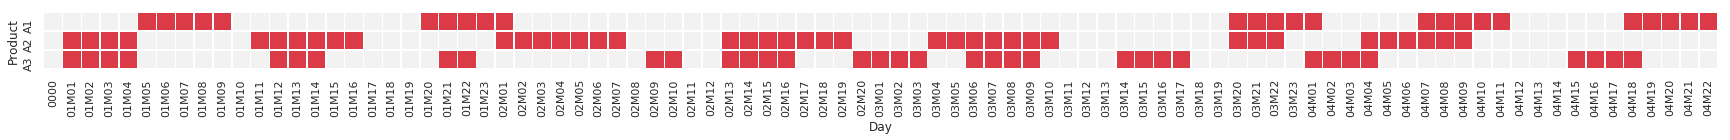

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

x_sol = pyo_df(model, 'on', ['Product', 'Day', 'Volume'])
x_sol = x_sol.pivot(index='Day', columns='Product', values='Volume')

sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(x_sol.T, cmap=cmap, center=0, square=True,
            linewidths=.5, cbar=False)

Let us now have a look at the quantities sold each month

In [0]:
x_sol = pyo_df(model, 's', ['Product', 'Day', 'Volume'])
x_sol = x_sol.pivot(index='Day', columns='Product', values='Volume')
Jan = x_sol[x_sol.index.str.contains('01M')].sum()
Feb = x_sol[x_sol.index.str.contains('02M')].sum()
Mar = x_sol[x_sol.index.str.contains('03M')].sum()
Apr = x_sol[x_sol.index.str.contains('04M')].sum()

In [237]:
pd.DataFrame([Jan, Feb, Mar, Apr], index=['Jan', 'Feb', 'Mar', 'Apr'])

Product,A1,A2,A3
Jan,4500.0,4500.0,4400.0
Feb,500.0,5400.0,4400.0
Mar,2000.0,5300.0,6050.0
Apr,5300.0,2700.0,4400.0


### Conclusion

We have shown how to model a firm's production line in this model. We came up with an increasingly detailed model and shown how a mathematical programming model can be solved to find optimal plannings under various constraints



### Credits

This work is an extension of a problem statement by Leo Liberti (Ecole Polytechnique)